# Lab 6
## Machine Learning

### Importing packages

As usual we begin by importing the necessary packages.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os
#os.environ["OMP_NUM_THREADS"] = "1" #This is to avoid a memory leakage issue with KMeans on Windows, uncomment if you are on Windows
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

SEED = 42

# The Wine Dataset

We have finally graduated from using our students dataset, and as recent graduates our first order of business is of course: Wine!

This weeks dataset is a quite famous dataset containing the chemical properties of wines derived from three different cultivars grown in the same region in Italy. It consists of 178 samples with 13 numerical features, such as alcohol content, flavonoids, and color intensity.

Remember to check out the data for more information here:
https://archive.ics.uci.edu/dataset/109/wine

In [69]:
wine = load_wine()
X = wine.data  # Feature matrix
y = wine.target  # Actual wine classes

We convert the X data to a DataFrame as a seperate object and print the first 5 rows.

In [70]:
df = pd.DataFrame(X, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


As we discussed in the lecture, we should scale our X variables, as both PCA and our clustering algorithms are sensitive to scale.

In [71]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

As we are doing unsupervised ML we don't need to create a training and test split, as there is no metric we need to calculate or optimise on!

Note the dataset does contain a 'true' label, which we will look at, but our goal today is not to recreate this label (a supervised classfication task) but instead unsupervised exploration of the dataset.

# Plotting the Data
To get an overview of the dataset, lets plot two variables at a time, as well as the 'true labels' from the dataset. See if by changing the feature i nthe x and y axis you can get a plot where the same features are roughly in the same location as one another. Which two features work best?

Notice we are now using Seaborn (sns) instead of matplotlib,  it is built on top of matplotlib and allows for a more visually appealing plotting. For more information on Seaborn you can visit https://seaborn.pydata.org/.

In [72]:
#list the features in the dataset
print(wine.feature_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


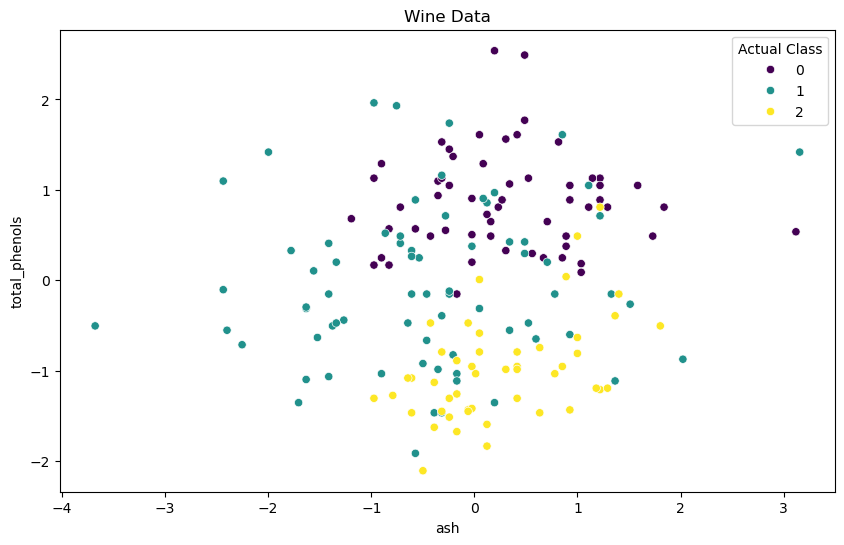

In [73]:
feature_x = 2 #Try changing this value to see how the scatter plot changes
feature_y = 5 #Try changing this value to see how the scatter plot changes

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, feature_x], y=X_scaled[:, feature_y], hue=y, palette='viridis')
plt.title("Wine Data")
plt.xlabel(wine.feature_names[feature_x])
plt.ylabel(wine.feature_names[feature_y])
plt.legend(title="Actual Class")
plt.show()

## PCA

Now we implement PCA, this is quite straightforward in python with the code below. Look at the proportion of variance explained and the graph below, after which component (n) do you think we can sefely drop the rest (i.e. reruning the PCA model with n_components=n)?

In [ ]:
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]
178


Create a plot which shows the proportion of variance explained by each component up to the 13th.

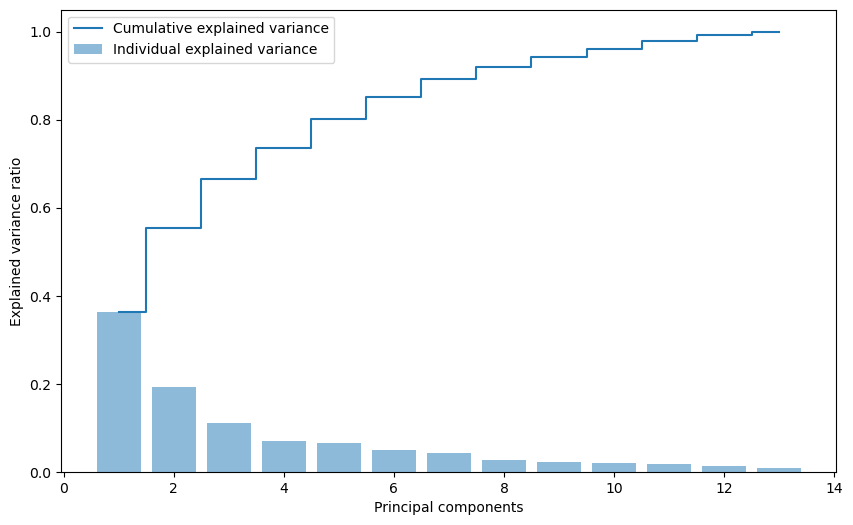

In [75]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

Now we plot the data as we did above, but this time with the PCA Components as our new features. Which two components give the cleanest split? Why is this?

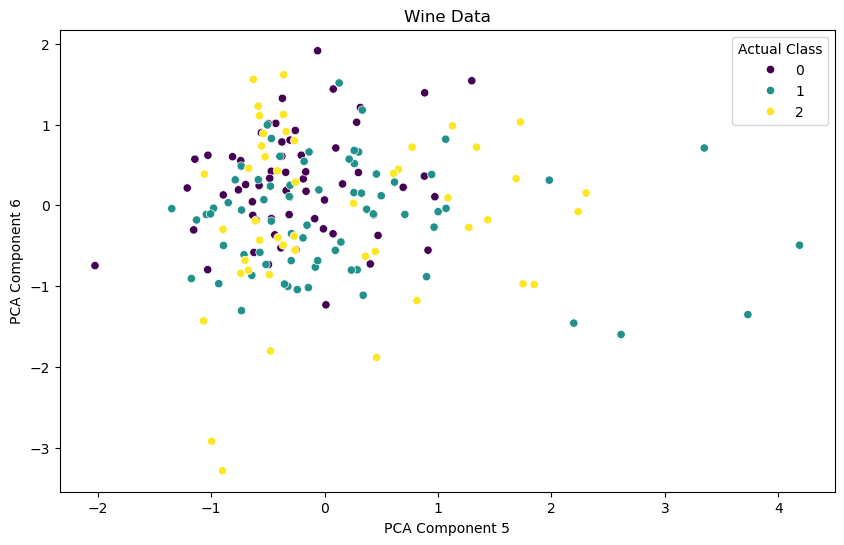

In [76]:
feature_x = 4
feature_y = 5

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, feature_x], y=X_pca[:, feature_y], hue=y, palette='viridis')
plt.title("Wine Data")
plt.xlabel("PCA Component " + str(feature_x + 1))
plt.ylabel("PCA Component " + str(feature_y + 1))
plt.legend(title="Actual Class")

Note: As we are facing a clustering problem, we want to see from which combination of PCs does the plot not show a meaningful distinction between groups anymore.

Now rerun the PCA with the number of components you think is optimal. We will then use this data to fit our clustering algorithms.

In [85]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.36198848 0.1920749 ]


# Clustering


## K-Means

Below we fit our K-means clustering algorithm. Use the same plot as above with PCA components 1 and 2 as the X and Y values to visualise the clustering. Try changing the number of clusers and see the results. Also try changing the seed (random_state) to see how stable the clustering is at different k values.

Hint: Set `hue=clusters`.

Bonus: You can also try changing the pca code above and see how different numbers of components in X_pca changes the clustering.

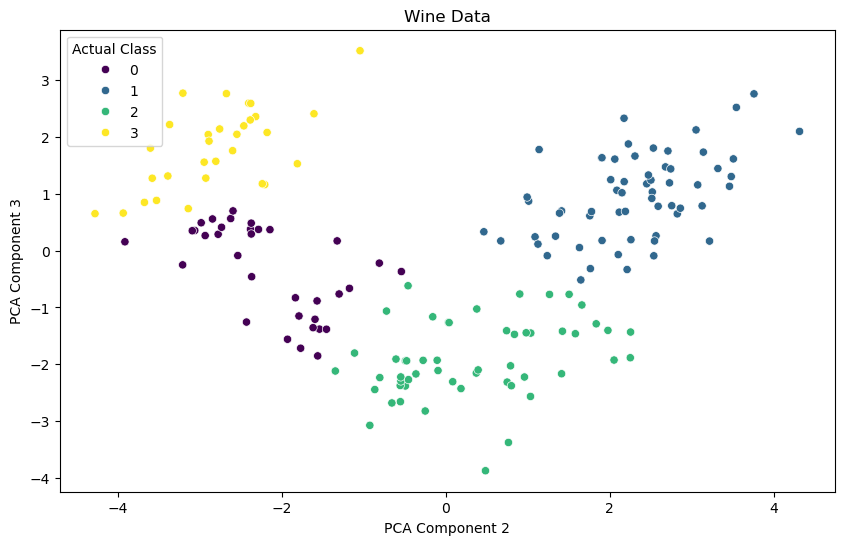

In [95]:
kmeans = KMeans(n_clusters=4, random_state=46)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title("Wine Data")
plt.xlabel("PCA Component " + str(feature_x + 1))
plt.ylabel("PCA Component " + str(feature_y + 1))
plt.legend(title="Actual Class")

## DBSCAN Clustering

DBSCAN is a density-based clustering algorithm that groups points that are closely packed together while marking outliers as noise. Unlike K-Means, DBSCAN does not require you to specify the number of clusters in advance.

DBSCAN relies on two parameters:
- `epsilon`(ε) – The maximum radius around a point to consider neighbors.
- `min_samples` – The minimum number of points required within ε to form a dense region.

DBSCAN classifies points into three categories:
- **Core Points:** Have at least min_samples points (including itself) within ε.
- **Border Points:** Are within ε of a core point but don’t have enough neighbors to be core points themselves. (In our plot below these will be the same as )
- **Noise Points:** (Outliers): Are neither core nor border points.

In [ ]:
# If you are getting strange results, try changing the PCA components
#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X_scaled)

In [ ]:
#Fit the DBSCAN algorithm here

In [ ]:
#Plot your clusters here

# Bonus: Your Own Clustering Algorithm

See if you can implement another clustering algorithm either from the options we saw in class or any other algorithm:

# Evaluating Clustering Algorithms

The silhouette score is one metric used to guage the quality of a clustering algorithm. It measures how well-separated the clusters are and how similar points within the same cluster are to each other. It ranges from 0 to 1, with higher meaning the clusters are more seperated.

BUT we should keep in mind that T=the silhouette score generally decreases as the number of clusters increases because smaller clusters tend to have higher compactness but may be closer to other clusters, so we cannot always make direct comparisons. And a higher silhouette score doesn't always mean a "better" number of clusters.

In [ ]:
#Compute the silhouette score for KMeans and DBSCAN
silhouette_kmeans = silhouette_score(X_pca, clusters)
silhouette_dbscan = silhouette_score(X_pca, clusters_db)
#calculate silhouette score for your own clustering algorithm here

print("Silhouette Score for KMeans:", silhouette_kmeans)
print("Silhouette Score for DBSCAN:", silhouette_dbscan)
#Print the silhouette score for your own clustering algorithm here

As Clustering is an unsuppervised method, there is no objective metric by which we can decide how well it has done. Often we use PCA and clustering as part of a semi-supervised process where we may eventually have a metric to give us insight. For 2D and 3D data a visual inspection is valid to decide  which algorithm is best. It is als overy important to consider what you actually want from the process and how your data is structured. Why is it important to find clusters in the first place, and on what criteria are we considering points to be well grouped. Consider these questions and look at our graphs to decide how you think the wines are best seperated!